In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
import h5py
from pykeops.torch import LazyTensor, generic_sum
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from scipy.special import gamma, kv

import sys
sys.path.append("../..")
from losses import squared_error, relative_error
from rkhs_functions import RKHSFunction
from constraints import Symmetric, FlipSymmetric
from helper import trapezoid_rule, standard_deviation

from training_functions import train_rkhs_pde

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

## Poisson Study of Kernel Size vs. Weight Discretization

In [3]:
sweeps = np.load("poisson_sweep.npz")
interp_res = sweeps["interp_res"][:, :, :, 0, :]
G_res = sweeps["G_res"][:, :, :, 0]
beta_res = sweeps["beta_res"][:, :, :, 0]
1 - np.mean(np.isnan(interp_res))

1.0

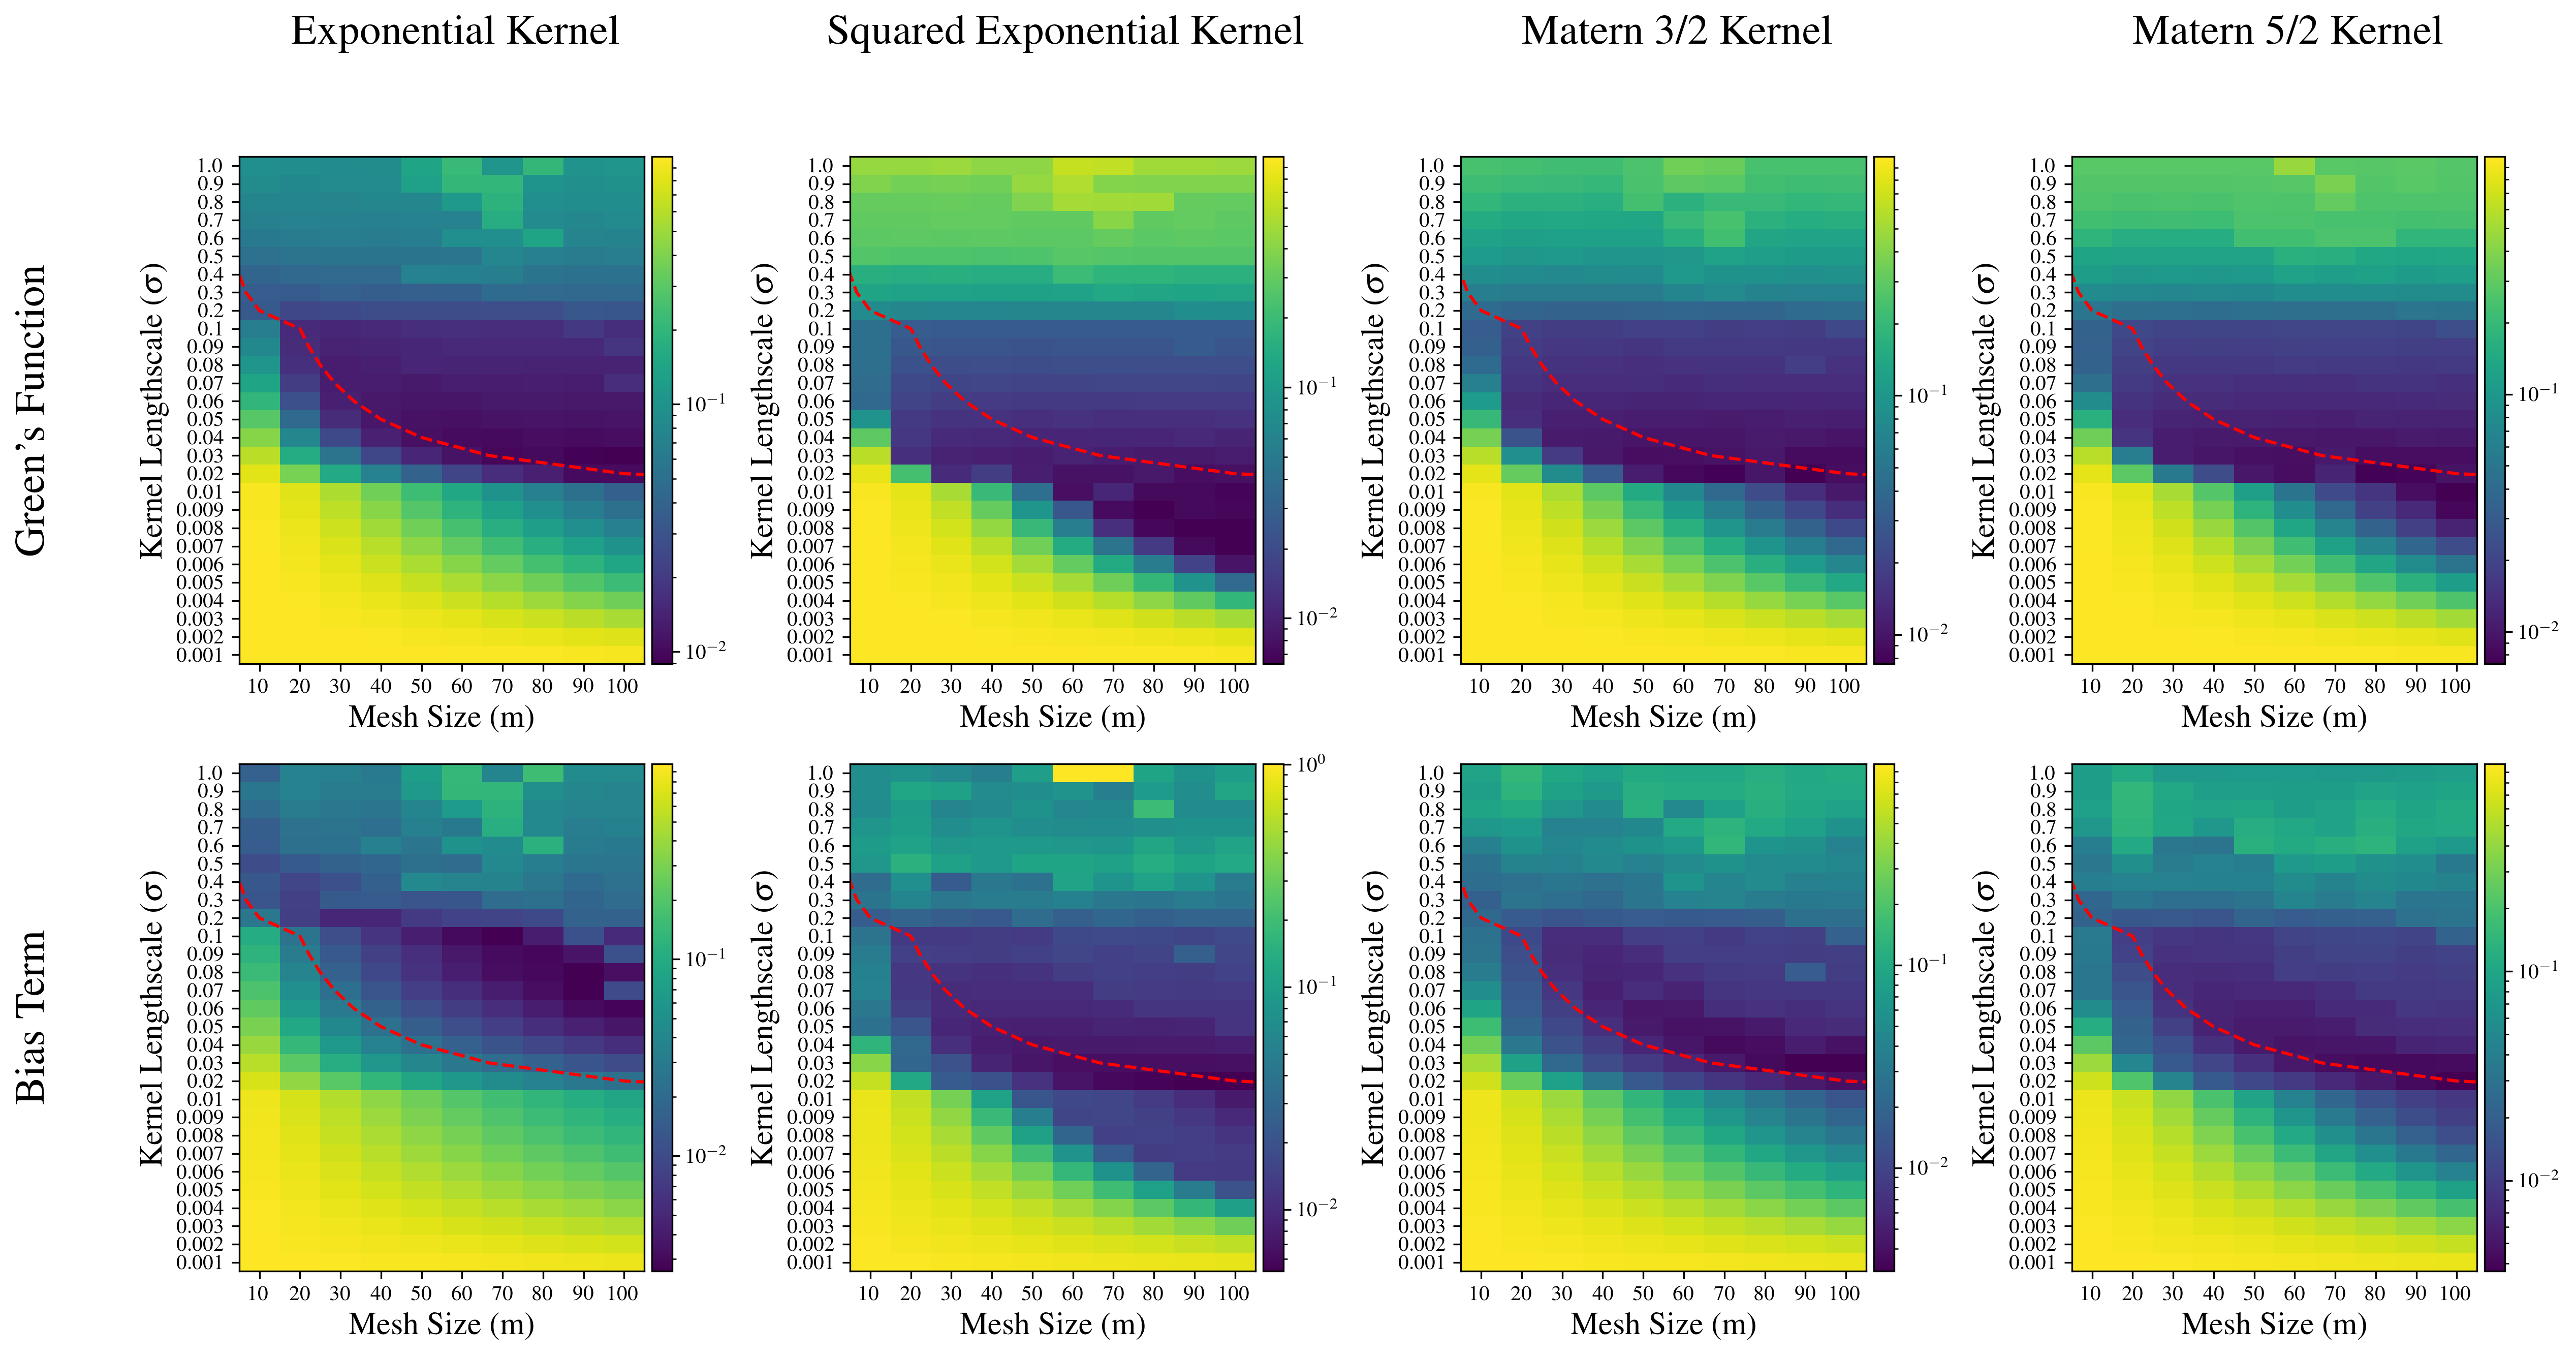

In [4]:
mx_weights = np.arange(10, 101, 10)
rkhs_kernel_widths = np.hstack([np.arange(1, 10) * 1e-3, np.arange(1, 10) * 1e-2, np.arange(1, 10) * 1e-1, 1])

fig, axs = plt.subplots(3, 5, figsize=(17, 9), gridspec_kw={'width_ratios':[0, 1, 1, 1, 1], 'height_ratios':[0, 1, 1]}, dpi=300)

axs[0, 0].remove()
axs[1, 0].set_ylabel("Green's Function", fontsize=20)
remove_spines(axs[1, 0])
axs[2, 0].set_ylabel("Bias Term", fontsize=20)
remove_spines(axs[2, 0])
axs[0, 1].set_title("Exponential Kernel", fontsize=20)
remove_spines(axs[0, 1])
axs[0, 2].set_title("Squared Exponential Kernel", fontsize=20)
remove_spines(axs[0, 2])
axs[0, 3].set_title("Matern 3/2 Kernel", fontsize=20)
remove_spines(axs[0, 3])
axs[0, 4].set_title("Matern 5/2 Kernel", fontsize=20)
remove_spines(axs[0, 4])

im = axs[1, 1].pcolormesh(G_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 1].set_xticklabels(mx_weights)
axs[1, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 1].set_xlim([0, len(mx_weights)])
axs[1, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 2].pcolormesh(G_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 2].set_xticklabels(mx_weights)
axs[1, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 2].set_xlim([0, len(mx_weights)])
axs[1, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 3].pcolormesh(G_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 3].set_xticklabels(mx_weights)
axs[1, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 3].set_xlim([0, len(mx_weights)])
axs[1, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 4].pcolormesh(G_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 4].set_xticklabels(mx_weights)
axs[1, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 4].set_xlim([0, len(mx_weights)])
axs[1, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 1].pcolormesh(beta_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 1].set_xticklabels(mx_weights)
axs[2, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 1].set_xlim([0, len(mx_weights)])
axs[2, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 2].pcolormesh(beta_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 2].set_xticklabels(mx_weights)
axs[2, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 2].set_xlim([0, len(mx_weights)])
axs[2, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 3].pcolormesh(beta_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 3].set_xticklabels(mx_weights)
axs[2, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 3].set_xlim([0, len(mx_weights)])
axs[2, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 4].pcolormesh(beta_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 4].set_xticklabels(mx_weights)
axs[2, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 4].set_xlim([0, len(mx_weights)])
axs[2, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

fig.tight_layout()
plt.savefig("../../figures/poisson_weight_hyperparams.png", bbox_inches="tight")
plt.show()

## Helmholtz Study of Kernel Size vs. Weight Discretization

In [5]:
sweeps = np.load("helmholtz_sweep.npz")
interp_res = sweeps["interp_res"][:, :, :, 0, :]
G_res = sweeps["G_res"][:, :, :, 0]
beta_res = sweeps["beta_res"][:, :, :, 0]
1 - np.mean(np.isnan(interp_res))

1.0

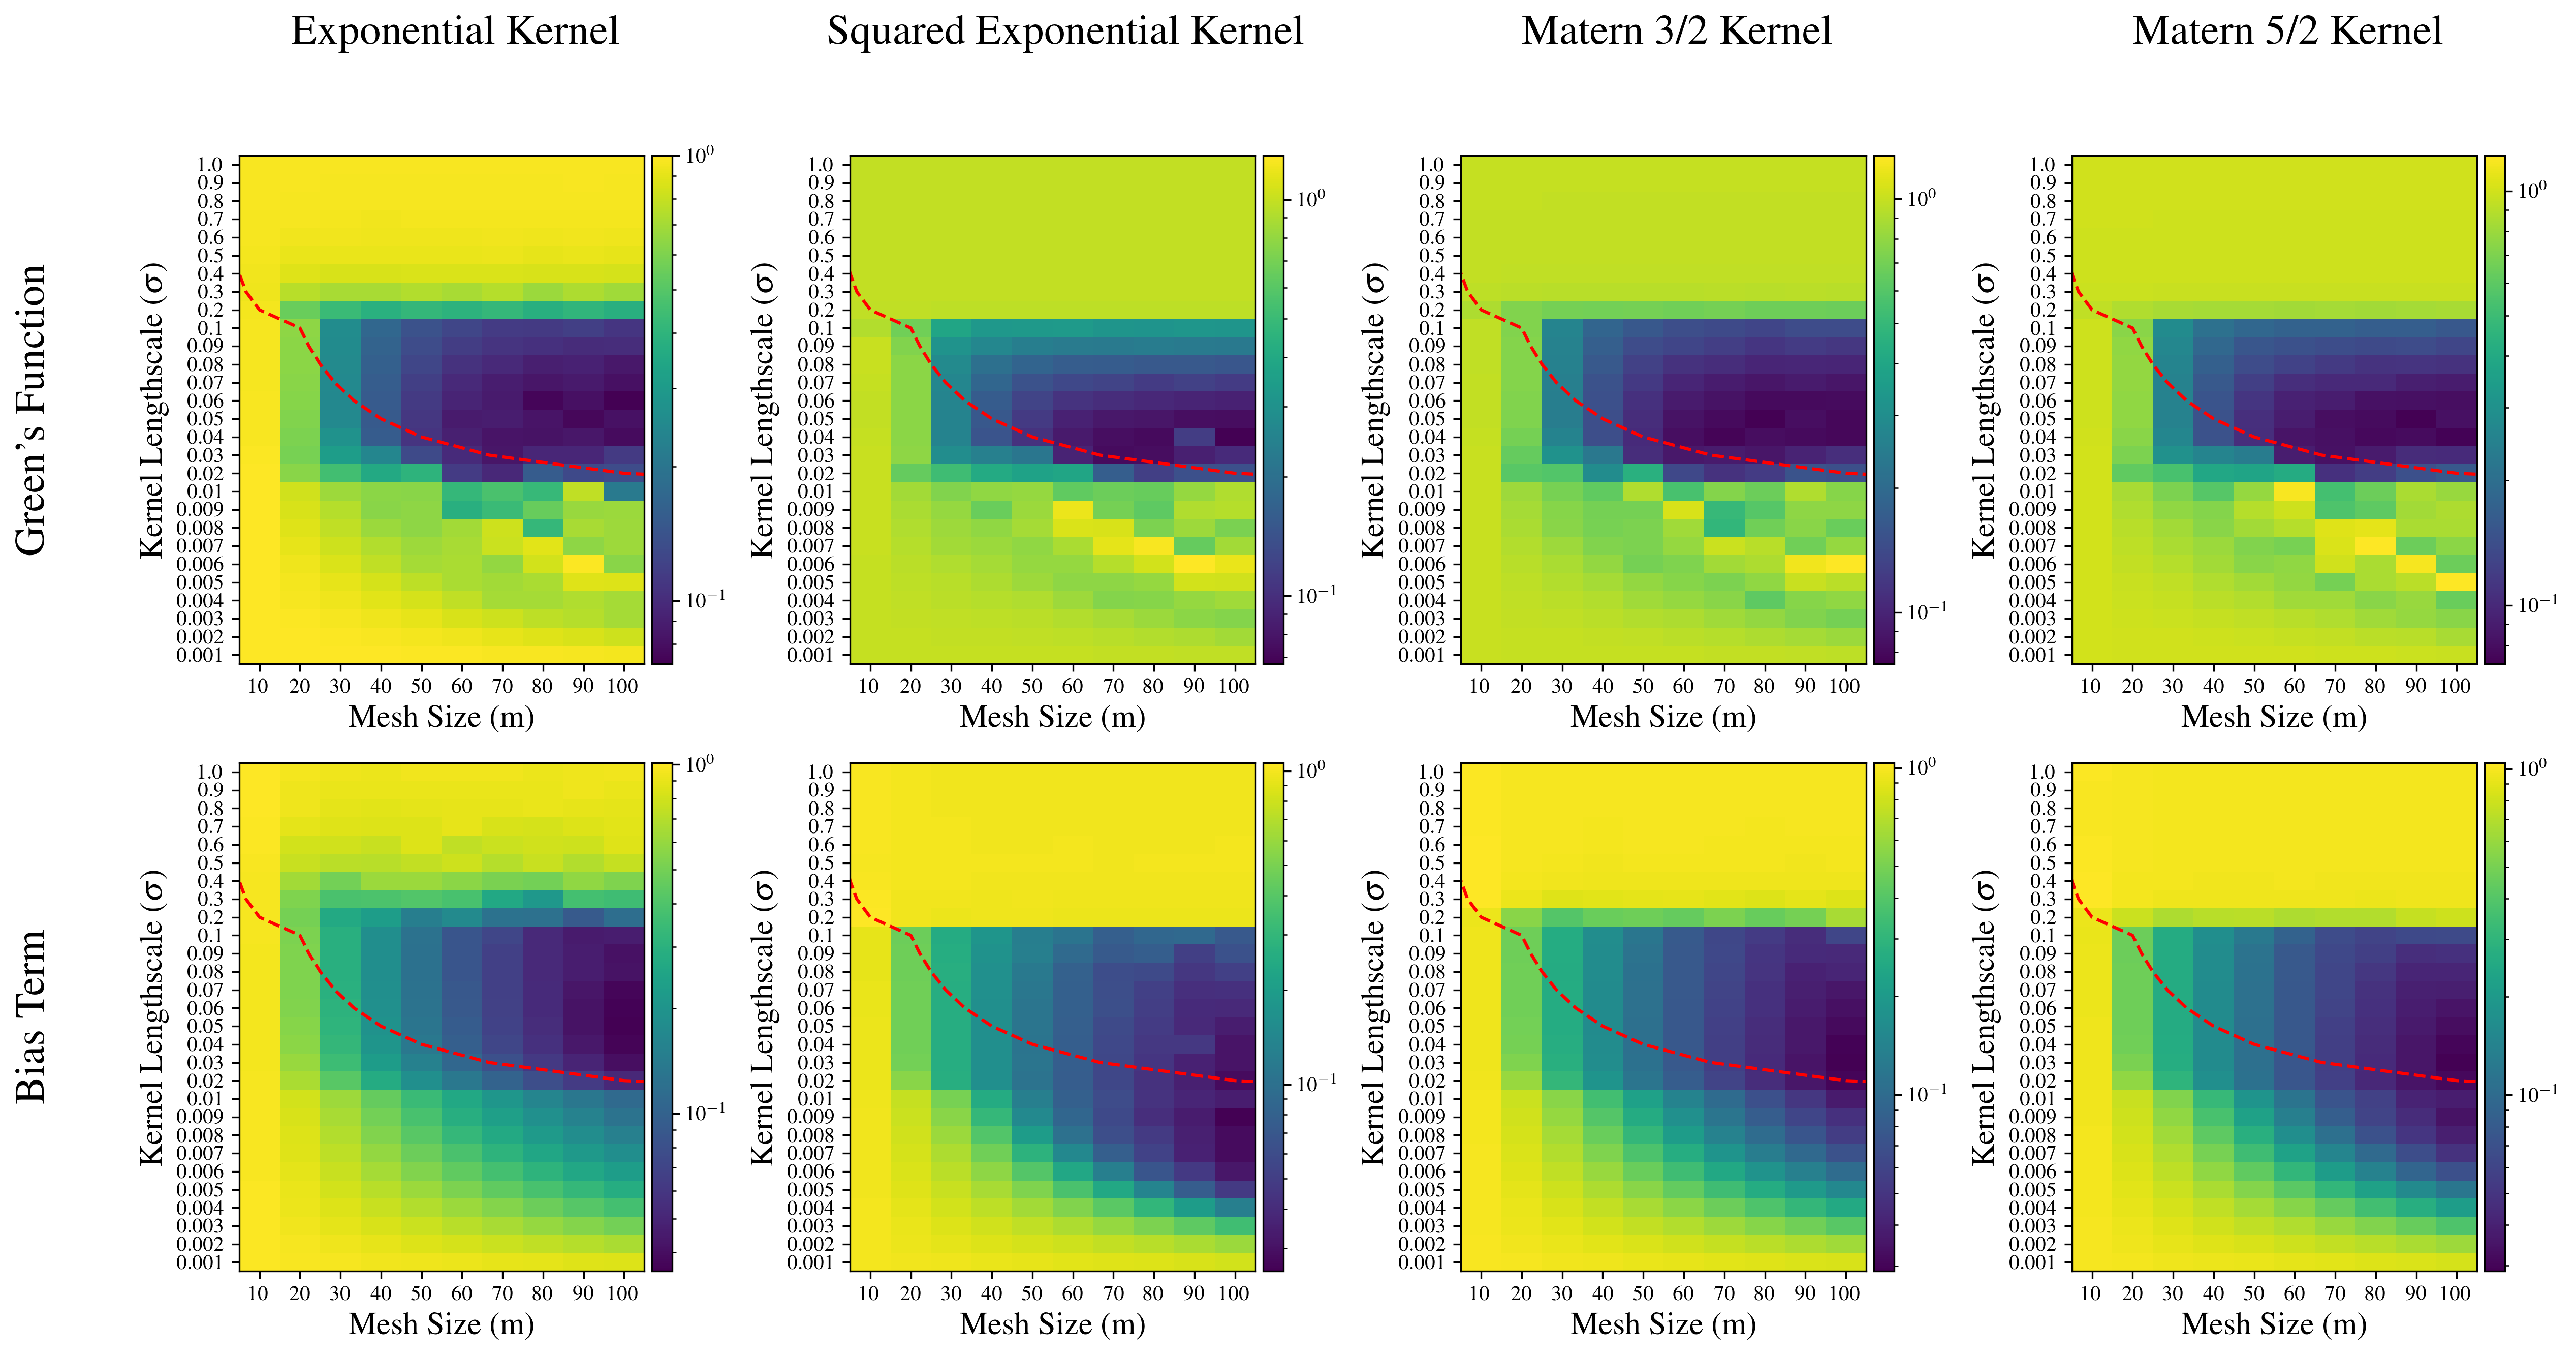

In [7]:
mx_weights = np.arange(10, 101, 10)
rkhs_kernel_widths = np.hstack([np.arange(1, 10) * 1e-3, np.arange(1, 10) * 1e-2, np.arange(1, 10) * 1e-1, 1])

fig, axs = plt.subplots(3, 5, figsize=(17, 9), gridspec_kw={'width_ratios':[0, 1, 1, 1, 1], 'height_ratios':[0, 1, 1]}, dpi=300)

axs[0, 0].remove()
axs[1, 0].set_ylabel("Green's Function", fontsize=20)
remove_spines(axs[1, 0])
axs[2, 0].set_ylabel("Bias Term", fontsize=20)
remove_spines(axs[2, 0])
axs[0, 1].set_title("Exponential Kernel", fontsize=20)
remove_spines(axs[0, 1])
axs[0, 2].set_title("Squared Exponential Kernel", fontsize=20)
remove_spines(axs[0, 2])
axs[0, 3].set_title("Matern 3/2 Kernel", fontsize=20)
remove_spines(axs[0, 3])
axs[0, 4].set_title("Matern 5/2 Kernel", fontsize=20)
remove_spines(axs[0, 4])

im = axs[1, 1].pcolormesh(G_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 1].set_xticklabels(mx_weights)
axs[1, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 1].set_xlim([0, len(mx_weights)])
axs[1, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 2].pcolormesh(G_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 2].set_xticklabels(mx_weights)
axs[1, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 2].set_xlim([0, len(mx_weights)])
axs[1, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 3].pcolormesh(G_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 3].set_xticklabels(mx_weights)
axs[1, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 3].set_xlim([0, len(mx_weights)])
axs[1, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[1, 4].pcolormesh(G_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[1, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[1, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[1, 4].set_xticklabels(mx_weights)
axs[1, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[1, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[1, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1, 4].set_xlim([0, len(mx_weights)])
axs[1, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[1, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 1].pcolormesh(beta_res[0, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 1].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 1].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 1].set_xticklabels(mx_weights)
axs[2, 1].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 1].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 1].set_xlim([0, len(mx_weights)])
axs[2, 1].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 1].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 2].pcolormesh(beta_res[1, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 2].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 2].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 2].set_xticklabels(mx_weights)
axs[2, 2].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 2].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 2].set_xlim([0, len(mx_weights)])
axs[2, 2].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 2].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 3].pcolormesh(beta_res[2, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 3].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 3].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 3].set_xticklabels(mx_weights)
axs[2, 3].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 3].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 3].set_xlim([0, len(mx_weights)])
axs[2, 3].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 3].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

im = axs[2, 4].pcolormesh(beta_res[3, :, :].T, norm=mpl.colors.LogNorm())
axs[2, 4].plot((2/rkhs_kernel_widths)/10-0.5, np.arange(len(rkhs_kernel_widths))+0.5, 'r--')
axs[2, 4].set_xticks(np.arange(len(mx_weights))+0.5)
axs[2, 4].set_xticklabels(mx_weights)
axs[2, 4].set_yticks(np.arange(len(rkhs_kernel_widths))+0.5)
axs[2, 4].set_yticklabels(np.round(rkhs_kernel_widths, 3))
divider = make_axes_locatable(axs[2, 4])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[2, 4].set_xlim([0, len(mx_weights)])
axs[2, 4].set_xlabel("Mesh Size (m)", fontsize=15)
axs[2, 4].set_ylabel("Kernel Lengthscale ($\sigma$)", fontsize=15)

fig.tight_layout()
plt.savefig("../../figures/helmholtz_weight_hyperparams.png", bbox_inches="tight")
plt.show()